#### **Import the required libraries**

We will be using a few libraries in this session, import all the required libraries in the cell below one by one as we go through the session.


In [ ]:
import os

import matplotlib.pyplot as plt
import torch
import tqdm
import yaml
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from torchvision import transforms
from torchvision.io import read_image

#### **Download the dataset**

We will be using `CIFAR-10` dataset for this session. The dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Please download the dataset using the following command.

```python
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/configs/linear_pytorch_config.yaml
!unzip -q CIFAR-10.zip -d .
```


In [ ]:
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/configs/linear_pytorch_config.yaml
!unzip -q CIFAR-10.zip -d .

--2024-02-13 16:15:13--  https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccdsiub/deeplearning-code-management/1.1/CIFAR-10.zip [following]
--2024-02-13 16:15:13--  https://raw.githubusercontent.com/ccdsiub/deeplearning-code-management/1.1/CIFAR-10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57166560 (55M) [application/zip]
Saving to: ‘CIFAR-10.zip’

CIFAR-10.zip        100%[===================>]  54.52M   142MB/s    in 0.4s    

2024-02-13 16:15:14 (142 MB/s) - ‘CIFAR-10.zip’ saved [57166560/57166560]

--2024-02

#### **Load configuration file**

We will be using a configuration file to store all the required parameters for the model. The configuration file is a YAML file, which is a human-readable data serialization standard that can be used in conjunction with all programming languages and is often used to write configuration files. Create a new file named `config.yaml` and add the following content to it.

```yaml
data_params:
  data_path: "CIFAR-10/"
```

Read the configuration file using the `yaml` library and store the data in a variable named `config`.


In [ ]:
file = open("linear_pytorch_config.yaml")
config = yaml.safe_load(file)
file.close()
print(config)

{'data_params': {'data_path': 'CIFAR-10/', 'train_ratio': 0.8, 'batch_size': 64}, 'model_params': {'input_size': 3072, 'num_classes': 10, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'gamma': 0.1, 'step_size': 5, 'num_epochs': 10}}


#### **Load the dataset**

Check the files in the side panel to see if the dataset is downloaded successfully. The dataset is organized in the following way.

```
CIFAR-10
 |
 └───airplane
 |
 └───automobile
 |
 └───bird
 |
 └───cat
 |
 └───deer
 |
 └───dog
 |
 └───frog
 |
 └───horse
 |
 └───ship
 |
 └───truck
```

Write a class named `CIFAR10Dataset` to load the dataset.


In [ ]:
class CIFAR10(torch.utils.data.Dataset):
    """The CIFAR10 dataset"""

    def __init__(self, root, transform=None, target_transform=None) -> None:
        """
        Initialize the CIFAR10 dataset

        :param root: The root directory of the dataset
        :type root: str
        :param transform: The transform to apply to the data
        :type transform: callable
        :param target_transform: The transform to apply to the target
        :type target_transform: callable

        :return: None
        :rtype: None
        """
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.targets = []

        self._load_data()

    def _load_data(self):
        """
        Load the data from the root directory

        :return: None
        :rtype: None
        """
        # Load the data
        for i, class_name in enumerate(os.listdir(self.root)):
            class_dir = os.path.join(self.root, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = read_image(image_path)
                self.data.append(image)
                self.targets.append(float(i))

    def __getitem__(self, index: int) -> tuple:
        """
        Get the item at the given index

        :param index: The index of the item
        :type index: int

        :return: The item at the given index
        :rtype: tuple
        """
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        """
        Get the length of the dataset

        :return: The length of the dataset
        :rtype: int
        """
        return len(self.data)

#### **Preprocess transformations**

Insted of loading the entire dataset into memory, and then applying transformations, we will be using `torchvision.transforms` to apply transformations while loading the dataset. We will use the following transformations:

1. `ToTensor`: Convert the image to a tensor with pixel values in the range [0, 1].
2. `Normalize`: Normalize the tensor with mean and standard deviation.
3. `Lambda`: To flatten the image tensor.


In [ ]:
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Lambda(lambda x: x.reshape(-1))
])

# you can transform the target too if you want (e.g. one hot encode)
target_transform = transforms.Lambda(
    lambda y: torch.tensor(y, dtype=torch.long))

Initialize the `CIFAR10Dataset` class with the `data_path` from the configuration file or you can use `torchvision.Dataset.ImageFolder` to load the dataset. Pass the transformations to the `CIFAR10Dataset` class and load the dataset.
You can load the class name from the folder using `os.listdir` for later use.


In [ ]:
data_path = config["data_params"]["data_path"]
classes = os.listdir(data_path)

dataset = CIFAR10(data_path, transform=transform,
                  target_transform=target_transform)

# dataset = ImageFolder(data_path, transform=transform,
#                      target_transform=target_transform)

#### **Split the data**

Use `torch.utils.data.random_split` to split the dataset into training and validation sets. Use 80% of the data for training and 10% for validation and 10% for testing.


In [ ]:
train_size = config["data_params"]["train_ratio"]
test_size = (1 - train_size) / 2
val_size = test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Validation size: {len(val_dataset)}")

Train size: 48001
Test size: 6000
Validation size: 5999


#### **Create data loaders**

Use `torch.utils.data.DataLoader` to create data loaders for training, validation, and testing datasets. Use a batch size from the configuration file.


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config["data_params"]["batch_size"],
    num_workers=torch.get_num_threads(),
    shuffle=True
)

#### **Linear Classifier PyTorch Model**

Create a class named `LinearClassifier` to define the model. The model will have a single linear layer with 10 output units, followed by a softmax layer.


In [ ]:
class LinearClassifier(torch.nn.Module):
    """The linear classifier model"""

    def __init__(self, input_size: int, num_classes: int) -> None:
        """
        Initialize the MLP model

        :param input_size: The input size
        :type input_size: int
        :param num_classes: The number of classes
        :type num_classes: int
        """
        super(LinearClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, num_classes)
        self.softmax = torch.nn.Softmax(dim=1)

    # This part is optional (Weight initialization)
    #     self.init_weights()

    # def init_weights(self):
    #     for m in self.modules():
    #         if type(m) == torch.nn.Linear:
    #             torch.nn.init.xavier_uniform_(m.weight)
    #             m.bias.data.fill_(0.01)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        :param x: The input tensor
        :type x: torch.Tensor

        :return: The output tensor
        :rtype: torch.Tensor
        """
        out = self.fc1(x)
        out = self.softmax(out)
        return out

#### **Initialize the model**

Initialize the model and define the loss function, optimizer, and scheduler. Use the loss function as `nn.CrossEntropyLoss`, optimizer as `torch.optim.Adam`, and scheduler as `torch.optim.lr_scheduler.StepLR`. Use the learning rate and step size from the configuration file. Use the device as `cuda` if available, else use `cpu`.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LinearClassifier(
    input_size=config["model_params"]["input_size"],
    num_classes=config["model_params"]["num_classes"]
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["model_params"]["learning_rate"],
    # L2 regularization
    weight_decay=config["model_params"]["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config["model_params"]["step_size"],
    gamma=config["model_params"]["gamma"]
)

##### **Validation function**

Create a function named `validate` to calculate the accuracy of the model on the validation dataset. Use the `model.eval` method to set the model to evaluation mode and use the `torch.no_grad` context manager to disable gradient calculation. Iterate through the validation data loader and calculate the accuracy of the model.


In [ ]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

#### **Training function**

Write a function named `train` to train the model. Use the `model.train` method to set the model to training mode. Iterate through the training data loader and calculate the loss and accuracy of the model. Use the `optimizer.zero_grad` method to zero the gradients and use the `loss.backward` method to backpropagate the loss. Use the `optimizer.step` method to update the model parameters. Use the `scheduler.step` method to update the learning rate.


In [ ]:
def train(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.StepLR,
    device: torch.device,
    num_epochs: int
) -> tuple:
    """
    Train the model

    :param model: The model to train
    :type model: torch.nn.Module
    :param train_loader: The training loader
    :type train_loader: torch.utils.data.DataLoader
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param optimizer: The optimizer
    :type optimizer: torch.optim.Optimizer
    :param scheduler: The learning rate scheduler
    :type scheduler: torch.optim.lr_scheduler.StepLR
    :param device: The device to use
    :type device: torch.device
    :param num_epochs: The number of epochs
    :type num_epochs: int

    :return: The trained model and the training history
    :rtype: tuple
    """
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm.tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)
        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=train_loss / (i + 1))

        train_loss /= len(train_loader)
        val_loss, val_acc, _ = validate(model, val_loader, criterion, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "history": history
            }
            torch.save(checkpoint, "checkpoint.pth")

        scheduler.step()

    return model, history

##### **Train the model**

Call the `train` function to train the model.


In [ ]:
model, history = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=config["model_params"]["num_epochs"]
)

Epoch [1/10]
Train loss: 2.1040
Validation loss: 2.0809
Validation accuracy: 0.38%


Epoch [2/10]
Train loss: 2.0748
Validation loss: 2.0743
Validation accuracy: 0.38%


Epoch [3/10]
Train loss: 2.0651
Validation loss: 2.0700
Validation accuracy: 0.39%


Epoch [4/10]
Train loss: 2.0569
Validation loss: 2.0693
Validation accuracy: 0.39%


Epoch [5/10]
Train loss: 2.0523
Validation loss: 2.0705
Validation accuracy: 0.39%


Epoch [6/10]
Train loss: 2.0326
Validation loss: 2.0586
Validation accuracy: 0.40%


Epoch [7/10]
Train loss: 2.0245
Validation loss: 2.0576
Validation accuracy: 0.40%


Epoch [8/10]
Train loss: 2.0226
Validation loss: 2.0566
Validation accuracy: 0.40%


Epoch [9/10]
Train loss: 2.0188
Validation loss: 2.0538
Validation accuracy: 0.40%


Epoch [10/10]
Train loss: 2.0181
Validation loss: 2.0543
Validation accuracy: 0.40%


#### **Plot the learning curve**

Plot the training loss and validation loss using `matplotlib`, keep both the training loss and validation loss in the same plot.


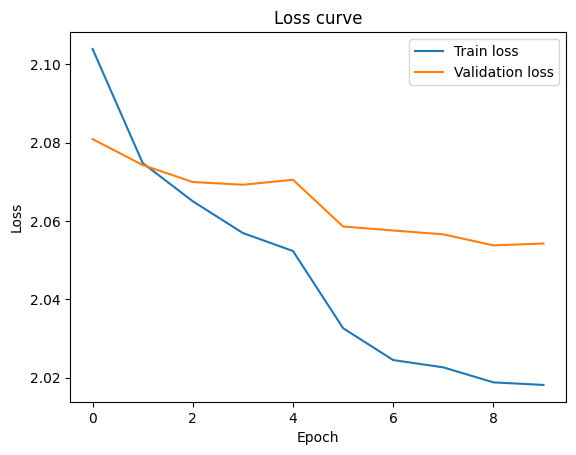

In [ ]:
plt.plot(history["train_loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **Load the model from the checkpoint**

Use `torch.load` to load the model from the checkpoint and use the `model.load_state_dict` method to load the model weights.


In [ ]:
model.load_state_dict(torch.load("checkpoint.pth")["model"])

<All keys matched successfully>

#### **Evaluate model performance**

Now, we have trained the model. Call the `validate` function to validate the model and calculate the loss and predicted labels on the testing data.

1. Use scikit-learn's `classification_report` function to evaluate the performance of the model. The `classification_report` function takes two inputs, `test_labels` and `predicted_labels`, and returns a report of the precision, recall, and F1-score of the model.
2. Use the `confusion_matrix` function to get the confusion matrix of the model. It also takes two inputs, `test_labels` and `predicted_labels`, and returns the confusion matrix of the model. Use `ConfusionMatrixDisplay` to display the confusion matrix.


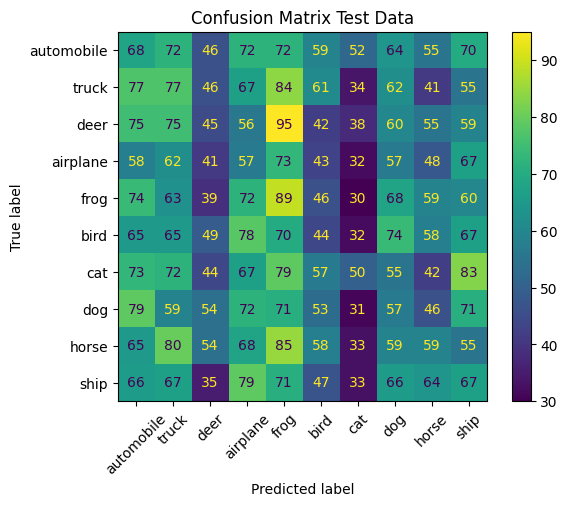




              precision    recall  f1-score   support

  automobile       0.10      0.11      0.10       630
       truck       0.11      0.13      0.12       604
        deer       0.10      0.07      0.09       600
    airplane       0.08      0.11      0.09       538
        frog       0.11      0.15      0.13       600
        bird       0.09      0.07      0.08       602
         cat       0.14      0.08      0.10       622
         dog       0.09      0.10      0.09       593
       horse       0.11      0.10      0.10       616
        ship       0.10      0.11      0.11       595

    accuracy                           0.10      6000
   macro avg       0.10      0.10      0.10      6000
weighted avg       0.10      0.10      0.10      6000



In [ ]:
_, _, y_pred = validate(model, test_loader, criterion, device)
y_test = [labels for _, labels in test_loader]
y_test = torch.cat(y_test).numpy()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))

#### **Visualize the weights**

We can visualize the weights of the model to see what the model has learned. Use `plt.imshow` to visualize the weights of the model.


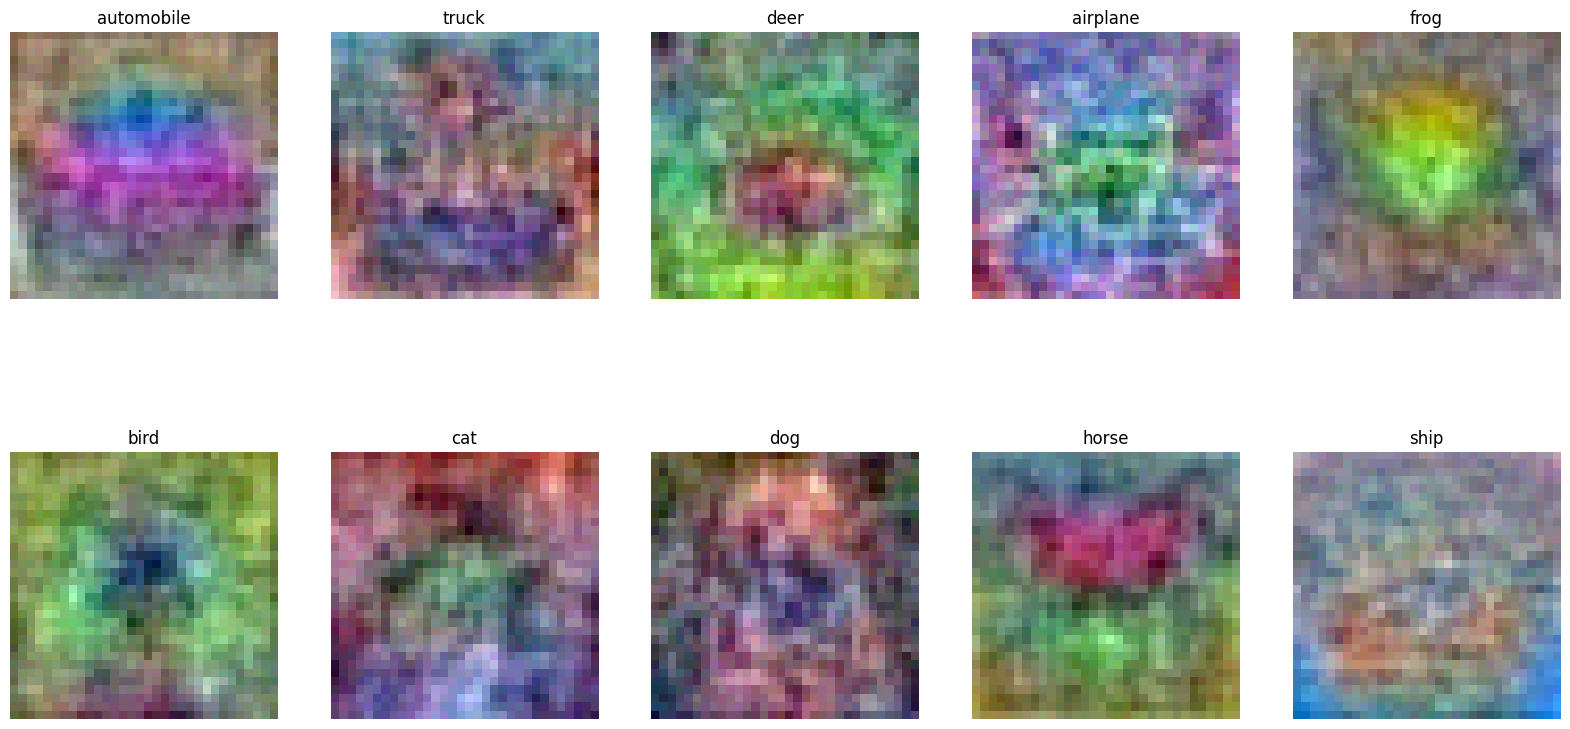

In [ ]:
weights = model.fc1.weight.data

fig, ax = plt.subplots(2, len(classes) // 2, figsize=(20, 10))
for i, class_name in enumerate(classes):
    row, col = i // 5, i % 5
    img = weights[i].reshape(3, 32, 32).permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype("uint8")
    ax[row, col].imshow(img)
    ax[row, col].set_title(class_name)
    ax[row, col].axis("off")
plt.show()